In [554]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [790]:
def get_nbr_pages(url):
    result = requests.get(url)
    src = result.content
    soup = BeautifulSoup(src)
    return int([a_tag.contents[0] for a_tag in soup.find_all('a', class_="button")][-2])

In [791]:
def get_next_url(url):
    result = requests.get(url)
    src = result.content
    soup = BeautifulSoup(src)
    next_url = soup.find('a', class_="next_page button button--primary")
    if next_url is not None:
        next_url = 'https://hemnet.se/' + next_url.attrs['href']
    return next_url

In [811]:
def get_columns(url):
    
    result = requests.get(url)
    src = result.content
    soup = BeautifulSoup(src)

    columns = []
    for a in soup.find_all('dt', text=lambda s: s != "Prisutveckling"):
        columns.append(a.contents[0])
    columns.append('Slutpris')
    columns.insert(0, 'Datum')
    columns.insert(1, 'Område')
    return columns

In [793]:
def scrape(urls):
    
    all_values = []
    for url in urls:
        values = []
        result = requests.get(url)
        src = result.content
        soup = BeautifulSoup(src)
        for a in soup.find_all('dd'):
            value = a.contents[0].strip(' kr').strip(' kr/m²').strip(' rum')\
                                 .strip(' kr/mån').strip(' kr/å').strip('\n').replace(u"\xa0", "").replace(',', '.')

            if 'Brf' not in value and value != '':
                values.append(value)
                
        # Gets the closing price 
        closing_price = soup.find_all('span', class_="sold-property__price-value")
        closing_price = closing_price[0].contents[0].strip(' kr').replace(u"\xa0", "")
        values.append(closing_price)
                
        # Gets the time of sale
        time = soup.find('time').contents[0].strip('\n').strip('\n    ')
        values.insert(0, time)
        
        # Gets the location of object
        area = soup.find("p").find("span") \
            .next_sibling.strip("Bostadsrättslägenhet -\n\n    Stockholm / ") \
            .strip("Stockholms kommun\n\n    - Såld den\n    ").strip(',')
        values.insert(1, area)
        
        all_values.append(values)
        
    return all_values

In [794]:
def get_search_urls(url):
    result = requests.get(url)
    src = result.content
    soup = BeautifulSoup(src)

    urls = []
    for li_tag in soup.find_all('li'):
        for div_tag in li_tag.find_all('div'):
            a_tag = div_tag.find('a')
            if a_tag != None:
                urls.append(a_tag.attrs['href'])

    urls = [x for x in urls if x.startswith("https://www.hemnet.se/")]
    return urls

In [795]:
search = 'https://www.hemnet.se/salda/bostader?item_types%5B%5D=bostadsratt&location_ids%5B%5D=473362&location_ids%5B%5D=898472&location_ids%5B%5D=473448&location_ids%5B%5D=925970&location_ids%5B%5D=925969&location_ids%5B%5D=925968&page=1&sold_age=all'

#next_url = get_next_url(search)

In [829]:
columns = [
        'Datum',
        'Område',
        'Pris per kvadratmeter',
        'Begärt pris',
        'Antal rum',
        'Boarea',
        'Avgift/månad',
        'Driftskostnad',
        'Byggår',
        'Slutpris'
        ]

In [853]:
current_search_page = search
i = 0
first = True
while get_next_url(current_search_page) is not None:
    
    if i > 100:
        break
    
    current_search_page = get_next_url(current_search_page)
    
    urls = get_search_urls(current_search_page)
    
    temp = pd.DataFrame(scrape(urls))
    
    if first != False:
        df = temp
        first = False
    
    df = pd.concat([df, temp])
    i += 1
    

In [854]:
df = df.drop(10, axis=1)

In [857]:
df = df.drop(11, axis=1)

In [858]:
df.columns = columns

In [890]:
df

,Datum,Område,Pris per kvadratmeter,Begärt pris,Antal rum,Boarea,Avgift/månad,Driftskostnad,Byggår,Slutpris
0,10 oktober 2019,Katarina - Rosenlundshöjden,75867,5690000,3,75,4237,8730,2019,5690000
1,10 oktober 2019,Hornstull,75756,5495000,3,79.4,3381,6600,1971,6015000
2,10 oktober 2019,Katarina,77679,3995000,2,56,2988,7216,1938,4350000
3,10 oktober 2019,Katarina,87059,2695000,1,34,1823,4560,1927,2960000
4,10 oktober 2019,Hornstull,85600,5495000,3,75,2941,7700,1912,6420000
...,...,...,...,...,...,...,...,...,...,...
45,18 januari 2019,fia,88667,2295000,1,30,1131,2100,1906,2660000
46,18 januari 2019,Maria,86486,4550000,2,55.5,2568,9857,1889,4800000
47,18 januari 2019,Östermalm,105932,5995000,2,59,2358,1914,6250000,None
48,18 januari 2019,Vasastan/Odenplan,121687,8990000,3,83,7000,1883,10100000,None


In [960]:
temp = df.loc[df.Slutpris.isna()]
temp.loc[:, 'Slutpris'] = temp['Byggår'].values
temp.loc[:, 'Byggår'] = temp['Driftskostnad'].values
temp.loc[:, 'Driftskostnad'] = '0'

temp2 = df.loc[~df.Slutpris.isna()]

data = pd.concat([temp, temp2])

data = data[~data.Slutpris.isna()].reset_index(drop=True)
#data = data[data['Begärt pris'] ]

# removes buildings without starting price
data = data.loc[data['Begärt pris'].astype(float) > 10000]

data.loc[:,'Byggår'] = data['Byggår'].map(lambda x: x[:4]).values
data = data[data['Avgift/månad'] != '    ']

to_float = ['Antal rum', 'Boarea']
to_int = ['Pris per kvadratmeter', 'Begärt pris', 'Driftskostnad', 'Avgift/månad', 'Byggår', 'Slutpris']

In [961]:
data[to_float] = data[to_float].astype(float)
#data[to_int] = data[to_int].astype(int)
#return data

In [962]:
data.loc[:,'Byggår'] = data['Byggår'].map(lambda x: x[:4]).values

In [963]:
for c in to_int:
    data[c] = pd.to_numeric(data[c], errors='coerce')

In [964]:
data

,Datum,Område,Pris per kvadratmeter,Begärt pris,Antal rum,Boarea,Avgift/månad,Driftskostnad,Byggår,Slutpris
0,10 oktober 2019,,101724,2695000,1.0,29.0,1328.0,0.0,1905.0,2950000.0
1,10 oktober 2019,Vasastan - Röda Bergen/Torsplan,75000,5250000,3.0,70.0,3556.0,0.0,1928.0,5250000.0
2,10 oktober 2019,Vasastan,128947,1995000,1.0,19.0,900.0,0.0,1906.0,2450000.0
3,10 oktober 2019,ödermalm,85342,6450000,3.0,80.5,2538.0,0.0,1969.0,6870000.0
4,10 oktober 2019,Östermalm,97170,4995000,2.5,53.0,2559.0,0.0,1943.0,5150000.0
...,...,...,...,...,...,...,...,...,...,...
4988,19 januari 2019,Östermalm,128800,2495000,1.0,25.0,325.0,4200.0,1921.0,3220000.0
4989,19 januari 2019,ödermalm,57500,3695000,2.5,64.0,4206.0,9360.0,2013.0,3680000.0
4990,18 januari 2019,fia,88667,2295000,1.0,30.0,1131.0,2100.0,1906.0,2660000.0
4991,18 januari 2019,Maria,86486,4550000,2.0,55.5,2568.0,9857.0,1889.0,4800000.0


In [965]:
month_map = {
        'januari' : '01',
        'februari' : '02',
        'mars' : '03',
        'april': '04',
        'maj' : '05',
        'juni' : '06',
        'juli' : '07',
        'augusti' : '08',
        'september' : '09',
        'oktober' : '10',
        'november' : '11',
        'december' : '12'
    }

In [966]:
month_series = data.Datum.apply(lambda x: x[3:-4].strip(' ')).map(month_map)
day_series = data.Datum.apply(lambda x: '-' + x[:2] + '-')
year_series = data.Datum.apply(lambda x: x[-4:])
data.Datum = month_series+day_series+year_series

In [968]:
data.Datum = pd.to_datetime(data.Datum)

In [969]:
data.to_csv('bostadsrätter_stockholm_2019.csv')

In [971]:
import matplotlib.pyplot as plt
plt.plot(data.Datum, data.Slutpris)

c:\users\erik.norlander\py36\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [983]:
pris = data['Pris per kvadratmeter']
pris.index = data.Datum

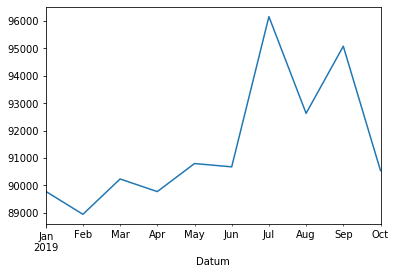

In [991]:
pris.resample('m').mean().plot()

In [992]:
data.Område

0                                      
1       Vasastan - Röda Bergen/Torsplan
2                              Vasastan
3                              ödermalm
4                             Östermalm
                     ...               
4988                          Östermalm
4989                           ödermalm
4990                                fia
4991                              Maria
4992                             Gärdet
Name: Område, Length: 4982, dtype: object

In [995]:
data

,Datum,Område,Pris per kvadratmeter,Begärt pris,Antal rum,Boarea,Avgift/månad,Driftskostnad,Byggår,Slutpris
0,2019-10-10,,101724,2695000,1.0,29.0,1328.0,0.0,1905.0,2950000.0
1,2019-10-10,Vasastan - Röda Bergen/Torsplan,75000,5250000,3.0,70.0,3556.0,0.0,1928.0,5250000.0
2,2019-10-10,Vasastan,128947,1995000,1.0,19.0,900.0,0.0,1906.0,2450000.0
3,2019-10-10,ödermalm,85342,6450000,3.0,80.5,2538.0,0.0,1969.0,6870000.0
4,2019-10-10,Östermalm,97170,4995000,2.5,53.0,2559.0,0.0,1943.0,5150000.0
...,...,...,...,...,...,...,...,...,...,...
4988,2019-01-19,Östermalm,128800,2495000,1.0,25.0,325.0,4200.0,1921.0,3220000.0
4989,2019-01-19,ödermalm,57500,3695000,2.5,64.0,4206.0,9360.0,2013.0,3680000.0
4990,2019-01-18,fia,88667,2295000,1.0,30.0,1131.0,2100.0,1906.0,2660000.0
4991,2019-01-18,Maria,86486,4550000,2.0,55.5,2568.0,9857.0,1889.0,4800000.0
